In [ ]:
#hide
#all_slow

# Training ResNet18-UNET

> Training notebook for this architecture.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/nbs/11_resnet18-UNET.ipynb)

In [1]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from steel_segmentation.all import *

import cv2
import fastai
import torch
import numpy as np
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

import albumentations as alb
import segmentation_models_pytorch as smp

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); device

device(type='cuda')

In [4]:
fastai.__version__, torch.__version__

('2.3.0', '1.7.1+cu101')

In [5]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [6]:
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [7]:
torch.cuda.empty_cache()

In [8]:
!nvidia-smi

Tue Apr  6 21:05:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   38C    P0    44W / 120W |      4MiB /  8126MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Actually testing the `get_segmnt_dls` Dataloader with `unet_learner` and `Learner` with `smp.Unet` architecure.

## Dataloader

In [9]:
def get_train_aug(height, width): return alb.Compose([
    alb.OneOf([
        alb.CropNonEmptyMaskIfExists(height, width, p=0.5),
        alb.RandomCrop(height, width, p=0.5)
    ], p=1.),
    alb.OneOf([
        alb.VerticalFlip(p=0.5),
        alb.HorizontalFlip(p=0.5)], p=0.8),
    alb.OneOf([
        alb.Blur(p=0.2),
        alb.CLAHE(p=0.5),
        alb.JpegCompression(p=0.5)
    ], p=0.8)
])

def get_valid_aug(height, width): return alb.Compose([alb.RandomCrop(height, width)])

In [10]:
size = (224,1568)

In [11]:
train_aug = get_train_aug(*size)
valid_aug = get_train_aug(*size)

In [12]:
dls = get_segmnt_dls(bs=16, train_aug=train_aug, valid_aug=valid_aug, device=device)

In [13]:
x, targ = dls.one_batch()
x.shape, targ.shape

(torch.Size([16, 3, 224, 1568]), torch.Size([16, 4, 224, 1568]))

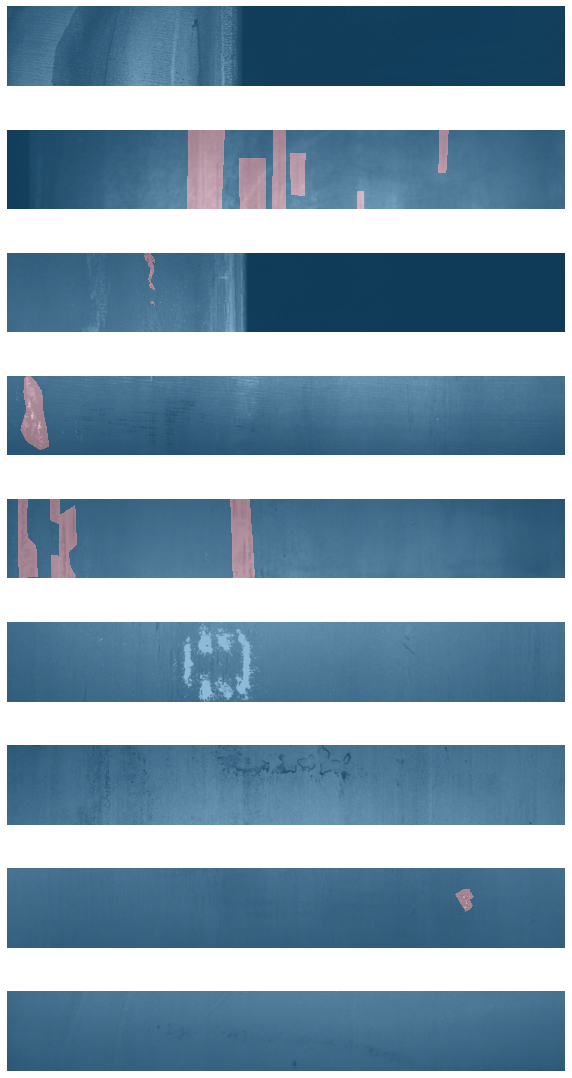

In [14]:
dls.show_batch(ncols=1, figsize=(10,20))

## Pytorch Learner

In [15]:
arch = smp.Unet('resnet18', classes=4, activation=None, decoder_attention_type='scse')

In [16]:
def opt_func(params, **kwargs): return OptimWrapper(params, torch.optim.Adam)

In [17]:
def splitter(m): return convert_params([[m.encoder], [m.decoder], [m.segmentation_head]])

First we train with `BCEWithLogitsLossFlat` and then fine-tune with `MultiClassesSoftBCEDiceLoss` as suggest [here](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/114254).

In [18]:
learn = Learner(dls=dls, 
                model=arch, 
                loss_func=BCEWithLogitsLossFlat(),
                metrics=[ModDiceMulti, dice_kaggle], 
                splitter=splitter, 
                opt_func=opt_func, 
                model_dir=models_dir, 
                cbs=[CudaCallback(), ShowGraphCallback()]).to_fp16()

In [19]:
learn.summary()

Unet (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 112 x 784 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                            

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=1.5848932266235352)

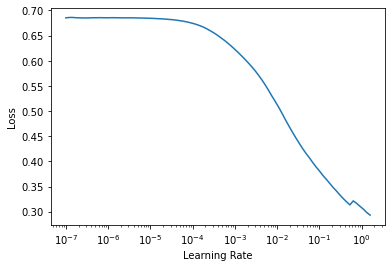

In [20]:
learn.lr_find()

In [21]:
stage = "resnet18-UNET-stage0"

In [22]:
fit_cbs = [
    GradientAccumulation(n_acc=32),
    CSVLogger(fname=f'logs/{stage}.csv'),
    SaveModelCallback(monitor='mod_dice_multi', comp=np.greater, fname=stage)]

In [ ]:
learn.fit_one_cycle(10, lr_max=3e-3, cbs=fit_cbs)

epoch,train_loss,valid_loss,mod_dice_multi,dice_kaggle,time


## Fastai Learner

In [ ]:
dls = get_segmnt_dls(bs=8, size=(256,800), flatten_mask=True, device=device)

In [ ]:
fast_learner = unet_learner(dls=dls, 
                            arch=resnet18, 
                            loss_func=MultiClassesSoftBCEDiceLoss(),
                            metrics=[ModDiceMulti], 
                            model_dir=models_dir, 
                            cbs=[CudaCallback(), ShowGraphCallback()])

In [ ]:
fast_learner.summary()

DynamicUnet (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 128 x 400  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [ ]:
fast_learner.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 620.00 MiB (GPU 0; 7.94 GiB total capacity; 5.01 GiB already allocated; 311.62 MiB free; 6.43 GiB reserved in total by PyTorch)